In [16]:
import sys
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.training import data_split_augment, train_model
from src.model import *
from src.visualization import *
from main import load_newest_model
from src.loader import load_and_preprocess_image

In [17]:
# Define the base directory for raw images
data_dir = os.path.join(project_root, "data", "raw")
data_dir

'c:\\Users\\antho\\Coding\\repos\\fruit-classifier\\data\\raw'

In [18]:
train_ds, val_ds, class_names = data_split_augment(data_dir, (224,224), 16)
test_directory = os.path.join(project_root, "data", "test")

Found 360 files belonging to 9 classes.


Using 288 files for training.
Found 360 files belonging to 9 classes.
Using 72 files for validation.


In [19]:
model_dir = os.path.join(project_root, "models")
model = load_newest_model(path=model_dir)
model.summary()

c:\Users\antho\Coding\repos\fruit-classifier\models\modelV3.keras loaded


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753,373 (10.50 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 330,260 (1.26 MB)

In [20]:
for layer in model.get_layer('mobilenetv2_1.00_224').layers:
    print(layer.name)

input_layer_2
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

<function matplotlib.pyplot.show(close=None, block=None)>

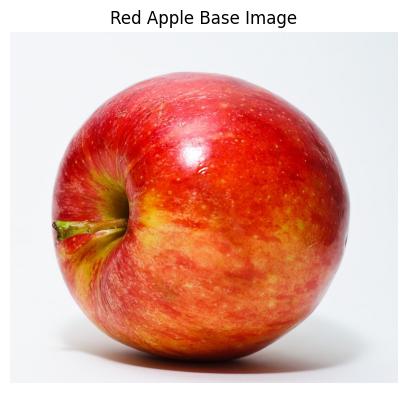

In [21]:
image_path = os.path.join(test_directory, "red_apple.jpg")
image = Image.open(image_path)
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.title("Red Apple Base Image")
plt.show

In [22]:
processed_image = load_and_preprocess_image(image_path)

# get feature maps of early, mid, and last convulational layers
early_fm = get_feature_map(model, layer_name="Conv1", preprocessed_image=processed_image)
mid_fm = get_feature_map(model, layer_name="block_2_expand_relu", preprocessed_image=processed_image)
late_fm = get_feature_map(model, layer_name="Conv_1", preprocessed_image=processed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


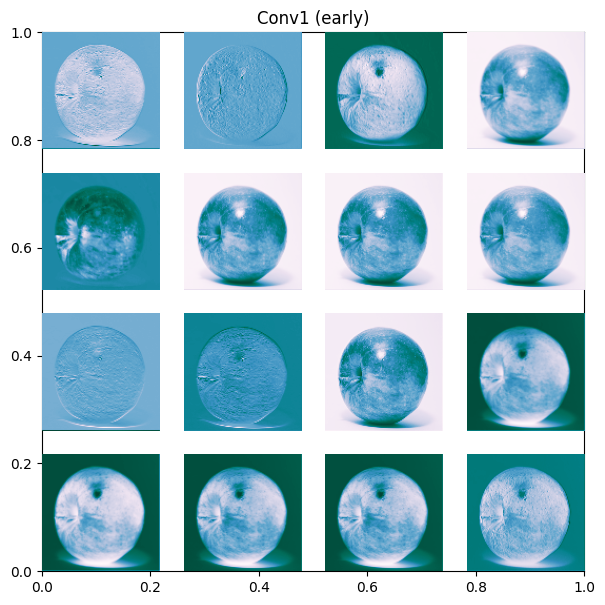

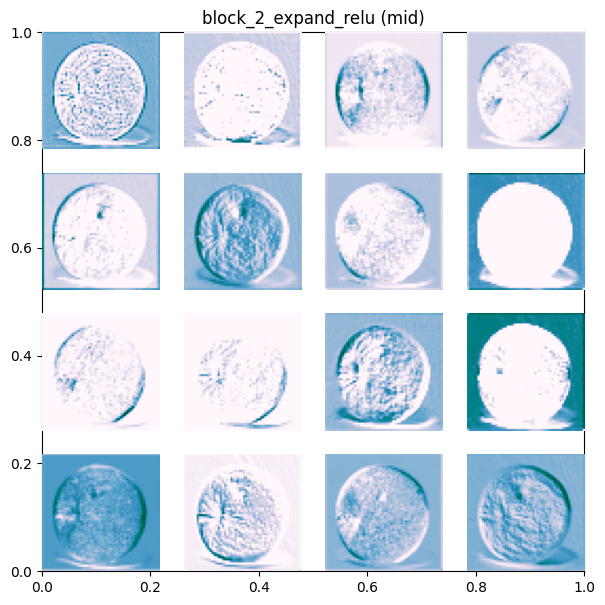

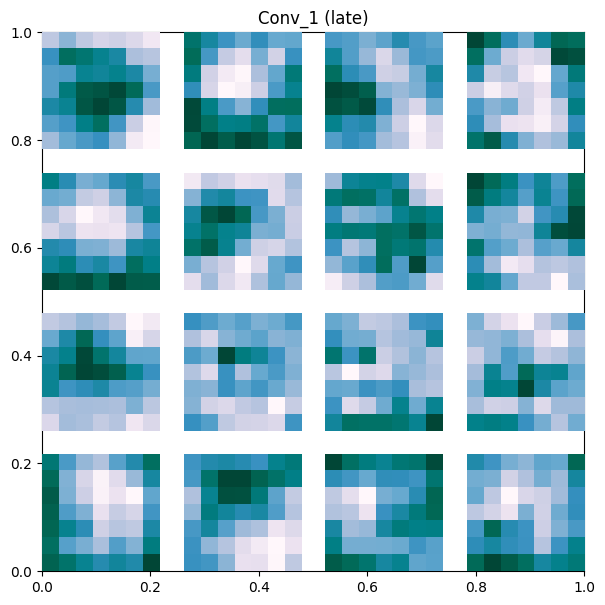

In [23]:
visualize_feature_map(early_fm, "Conv1 (early)")
visualize_feature_map(mid_fm, "block_2_expand_relu (mid)")
visualize_feature_map(late_fm, "Conv_1 (late)")

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense

In [25]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  

input_tensor = Input(shape=(224, 224, 3))

# Feature Map model
conv_model = Model(inputs=base_model.input, outputs=base_model.get_layer("Conv_1").output)

# Prediction model
x = base_model(input_tensor)
x = GlobalAveragePooling2D()(x)
predictions = Dense(9, activation="softmax")(x)
pred_model = Model(inputs=input_tensor, outputs=predictions)


In [26]:
# Create dummy input
dummy_input = np.random.random((1, 224, 224, 3)).astype("float32")

# Test conv_model for feature maps
try:
    conv_outputs = conv_model(dummy_input)
    print(f"Conv layer output shape: {conv_outputs.shape}")  # Expected: (1, 7, 7, 1280)
except Exception as e:
    print(f"Error with conv_model: {e}")

# Test pred_model for predictions
try:
    predictions = pred_model(dummy_input)
    print(f"Predictions shape: {predictions.shape}")  # Expected: (1, 9)
except Exception as e:
    print(f"Error with pred_model: {e}")



Conv layer output shape: (1, 7, 7, 1280)
Predictions shape: (1, 9)


In [27]:
# Get feature maps for Grad-CAM
conv_outputs = conv_model(processed_image)
print(f"Conv layer output shape: {conv_outputs.shape}")

# Get predictions
predictions = pred_model(processed_image)
print(f"Predictions: {predictions}")

Conv layer output shape: (1, 7, 7, 1280)
Predictions: [[0.04977002 0.11564525 0.06904578 0.17085966 0.22019938 0.06258567
  0.12033037 0.12442806 0.06713572]]


In [28]:
def make_gradcam_heatmap(conv_model, pred_model, img_arr, pred_idx=None):
    with tf.GradientTape() as tape:
        conv_out = conv_model(img_arr)
        tape.watch(conv_out)  

        # Temp connect feat map to dense layer

        # Global average pool
        x = tf.reduce_mean(conv_out, axis=(1, 2))  

        #pooled to dense
        pred = pred_model.layers[-1](x)  

        # Select the target class if not specified
        if pred_idx is None:
            # top pred
            pred_idx = tf.argmax(pred[0]) 
        class_channel = pred[:, pred_idx]

    # Compute grads
    grads = tape.gradient(class_channel, conv_out)
    if grads is None:
        raise ValueError("No grads oops")

    # fine important grad
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute Grad-CAM heatmap
    conv_out = conv_out[0] 
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_out), axis=-1)

    # Normalize
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [29]:
heatmap_apple = make_gradcam_heatmap(conv_model, pred_model, processed_image)

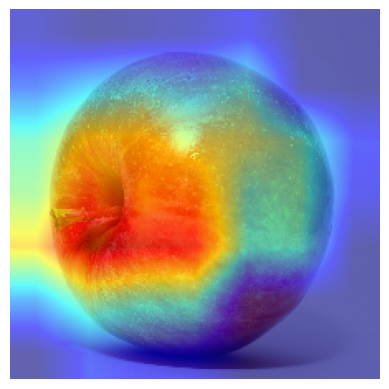

In [31]:
import cv2
def overlay_heatmap(heatmap, img_path, alpha=0.6):

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap) 
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) 
    overlay_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return overlay_img

oi = overlay_heatmap(heatmap_apple, image_path)
plt.imshow(cv2.cvtColor(oi, cv2.COLOR_BGR2RGB))
plt.title("")
plt.axis("off")
plt.show()
plt.close()

In [36]:
def grad_cam_plot_pred(conv_model, pred_model, img_path, class_names):
    processed = load_and_preprocess_image(img_path)
    heatmap = make_gradcam_heatmap(conv_model, pred_model, processed)
    overlay = overlay_heatmap(heatmap, img_path)

    pred = model.predict(processed)
    pred_idx = np.argmax(pred[0])
    confidence = pred[0][pred_idx]
    pred_label = class_names[pred_idx]

    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"{pred_label}: {confidence * 100:.2f}%")
    plt.axis("off")
    plt.show()
    plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step


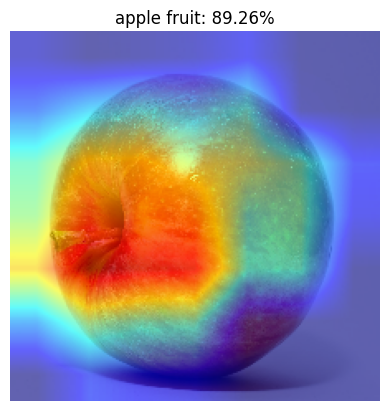

In [37]:
grad_cam_plot_pred(
    conv_model=conv_model,
    pred_model=pred_model,
    img_path=image_path,
    class_names=class_names
)


In [38]:
def grad_cam_grid(conv_model, pred_model, img_paths, class_names, grid_cols=3):
    num_img = len(img_paths)
    grid_rows = (num_img + grid_cols - 1) // grid_cols 

    plt.figure(figsize=(15, 5 * grid_rows)) 

    for i, img_path in enumerate(img_paths):
        plt.subplot(grid_rows, grid_cols, i + 1)

        # Call the existing function to gen
        grad_cam_plot_pred(conv_model, pred_model, img_path, class_names)

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


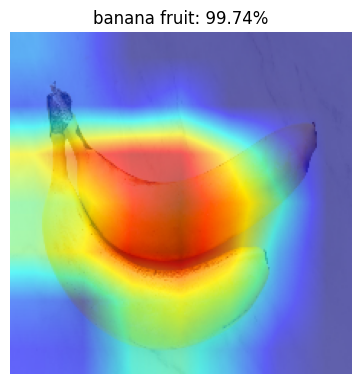

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


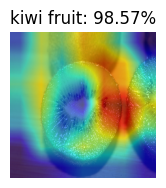

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


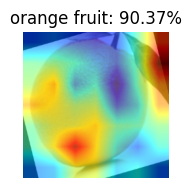

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


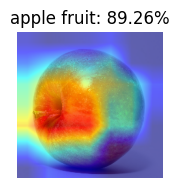

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


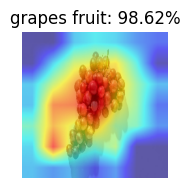

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


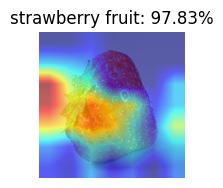

<Figure size 640x480 with 0 Axes>

In [39]:
image_paths = [os.path.join(test_directory, img) for img in os.listdir(test_directory)]

grad_cam_grid(
    conv_model=conv_model,
    pred_model=pred_model,
    img_paths=image_paths,
    class_names=class_names,
    grid_cols=3
)